In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [4]:
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
g_lr = 0.0001
d_lr = 0.0004
epochs = 30
nz = 100  # Size of the latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
nc = 3  # Number of channels (RGB)

# Define data transformation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Initialize generator and discriminator
netG = Generator(nz, ngf, nc).to(device)
netG.apply(weights_init)
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(0.5, 0.999))

100%|██████████| 170498071/170498071 [00:01<00:00, 90747194.25it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [12]:
d_losses = []
g_losses = []

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        # Update discriminator network
        netD.zero_grad()
        real_data = data[0].to(device)
        batch_size_curr = real_data.size(0)
        label = torch.full((batch_size_curr,), 0.9, device=device,dtype=torch.float32)
        real_data=0.9*real_data+0.1*torch.randn((real_data.size()), device=device)

        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size_curr, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0.1)
        fake_data=0.9*fake_data+0.1*torch.randn((fake_data.size()), device=device)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update generator network
        netG.zero_grad()
        label.fill_(0.9)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

    d_losses.append(errD.item())
    g_losses.append(errG.item())

    print(f"[Epoch {epoch+1}/{epochs}] Loss_D: {errD.item()}, Loss_G: {errG.item()}, D(x): {D_x}, D(G(z)): {D_G_z1}/{D_G_z2}")

# Save the trained model
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")

Epoch 1/30: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s]


[Epoch 1/30] Loss_D: 0.8818364143371582, Loss_G: 1.4490407705307007, D(x): 0.6784055829048157, D(G(z)): 0.2006375789642334/0.22563815116882324


Epoch 2/30: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


[Epoch 2/30] Loss_D: 0.8719348907470703, Loss_G: 1.153615117073059, D(x): 0.7069376707077026, D(G(z)): 0.2331559658050537/0.31090274453163147


Epoch 3/30: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


[Epoch 3/30] Loss_D: 1.1670892238616943, Loss_G: 1.0380544662475586, D(x): 0.4704535901546478, D(G(z)): 0.10722943395376205/0.36241522431373596


Epoch 4/30: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


[Epoch 4/30] Loss_D: 0.9769638776779175, Loss_G: 1.696615219116211, D(x): 0.6758649349212646, D(G(z)): 0.3017602562904358/0.17175011336803436


Epoch 5/30: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


[Epoch 5/30] Loss_D: 1.113969326019287, Loss_G: 3.0186214447021484, D(x): 0.850816547870636, D(G(z)): 0.4949282109737396/0.040187492966651917


Epoch 6/30: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


[Epoch 6/30] Loss_D: 0.8348228931427002, Loss_G: 1.5364223718643188, D(x): 0.7375332117080688, D(G(z)): 0.206984743475914/0.2074982225894928


Epoch 7/30: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]


[Epoch 7/30] Loss_D: 0.9798152446746826, Loss_G: 1.5513757467269897, D(x): 0.6207269430160522, D(G(z)): 0.21906410157680511/0.2024901956319809


Epoch 8/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


[Epoch 8/30] Loss_D: 1.0624185800552368, Loss_G: 2.7576441764831543, D(x): 0.889657199382782, D(G(z)): 0.4606609046459198/0.05586453154683113


Epoch 9/30: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


[Epoch 9/30] Loss_D: 1.3314319849014282, Loss_G: 0.8580213785171509, D(x): 0.39520758390426636, D(G(z)): 0.11064324527978897/0.4318118691444397


Epoch 10/30: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]


[Epoch 10/30] Loss_D: 1.0649075508117676, Loss_G: 3.244096517562866, D(x): 0.9006549119949341, D(G(z)): 0.46753358840942383/0.03289410471916199


Epoch 11/30: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


[Epoch 11/30] Loss_D: 0.9578560590744019, Loss_G: 1.5793993473052979, D(x): 0.7575256824493408, D(G(z)): 0.34501129388809204/0.1960594356060028


Epoch 12/30: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


[Epoch 12/30] Loss_D: 1.0982449054718018, Loss_G: 3.150878667831421, D(x): 0.8132730722427368, D(G(z)): 0.44901153445243835/0.038176726549863815


Epoch 13/30: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]


[Epoch 13/30] Loss_D: 0.9962722063064575, Loss_G: 0.8790464401245117, D(x): 0.5779363512992859, D(G(z)): 0.09738858044147491/0.4340801239013672


Epoch 14/30: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


[Epoch 14/30] Loss_D: 1.406212329864502, Loss_G: 3.5983376502990723, D(x): 0.9261966943740845, D(G(z)): 0.61139315366745/0.023036137223243713


Epoch 15/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


[Epoch 15/30] Loss_D: 0.8473044633865356, Loss_G: 1.7069752216339111, D(x): 0.7636249661445618, D(G(z)): 0.24099965393543243/0.16682536900043488


Epoch 16/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


[Epoch 16/30] Loss_D: 1.056423306465149, Loss_G: 1.1710014343261719, D(x): 0.5503663420677185, D(G(z)): 0.12224306911230087/0.3180086016654968


Epoch 17/30: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


[Epoch 17/30] Loss_D: 1.0370315313339233, Loss_G: 1.0111489295959473, D(x): 0.5829055905342102, D(G(z)): 0.1961664855480194/0.3759364187717438


Epoch 18/30: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


[Epoch 18/30] Loss_D: 1.259121298789978, Loss_G: 1.241170883178711, D(x): 0.4603056013584137, D(G(z)): 0.10374891757965088/0.30961132049560547


Epoch 19/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


[Epoch 19/30] Loss_D: 0.9424722790718079, Loss_G: 1.9809961318969727, D(x): 0.6926621794700623, D(G(z)): 0.27279365062713623/0.12376201152801514


Epoch 20/30: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]


[Epoch 20/30] Loss_D: 0.8843393325805664, Loss_G: 1.872153878211975, D(x): 0.7730923295021057, D(G(z)): 0.29079046845436096/0.14192548394203186


Epoch 21/30: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]


[Epoch 21/30] Loss_D: 0.9172044992446899, Loss_G: 2.1506195068359375, D(x): 0.7679063677787781, D(G(z)): 0.31677451729774475/0.1031244620680809


Epoch 22/30: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


[Epoch 22/30] Loss_D: 0.9514203667640686, Loss_G: 1.539913535118103, D(x): 0.6164036989212036, D(G(z)): 0.0746719166636467/0.21904850006103516


Epoch 23/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]


[Epoch 23/30] Loss_D: 0.884976863861084, Loss_G: 1.7667614221572876, D(x): 0.7650337815284729, D(G(z)): 0.2647581696510315/0.16793470084667206


Epoch 24/30: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


[Epoch 24/30] Loss_D: 1.2648932933807373, Loss_G: 1.0295175313949585, D(x): 0.4692700505256653, D(G(z)): 0.20430926978588104/0.38040128350257874


Epoch 25/30: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]


[Epoch 25/30] Loss_D: 0.9017109870910645, Loss_G: 1.4042752981185913, D(x): 0.7154173851013184, D(G(z)): 0.2523201107978821/0.23233549296855927


Epoch 26/30: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]


[Epoch 26/30] Loss_D: 0.8644958734512329, Loss_G: 1.8900635242462158, D(x): 0.732444167137146, D(G(z)): 0.2299516201019287/0.14362560212612152


Epoch 27/30: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


[Epoch 27/30] Loss_D: 0.8422910571098328, Loss_G: 1.9153187274932861, D(x): 0.7976022958755493, D(G(z)): 0.27419552206993103/0.13145068287849426


Epoch 28/30: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]


[Epoch 28/30] Loss_D: 0.8902007937431335, Loss_G: 1.3420053720474243, D(x): 0.6856474280357361, D(G(z)): 0.20079708099365234/0.257081538438797


Epoch 29/30: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


[Epoch 29/30] Loss_D: 1.1125142574310303, Loss_G: 0.8491790890693665, D(x): 0.49532148241996765, D(G(z)): 0.08972272276878357/0.4491427540779114


Epoch 30/30: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]

[Epoch 30/30] Loss_D: 0.8840574026107788, Loss_G: 2.7596652507781982, D(x): 0.8007648587226868, D(G(z)): 0.3100667893886566/0.052194274961948395


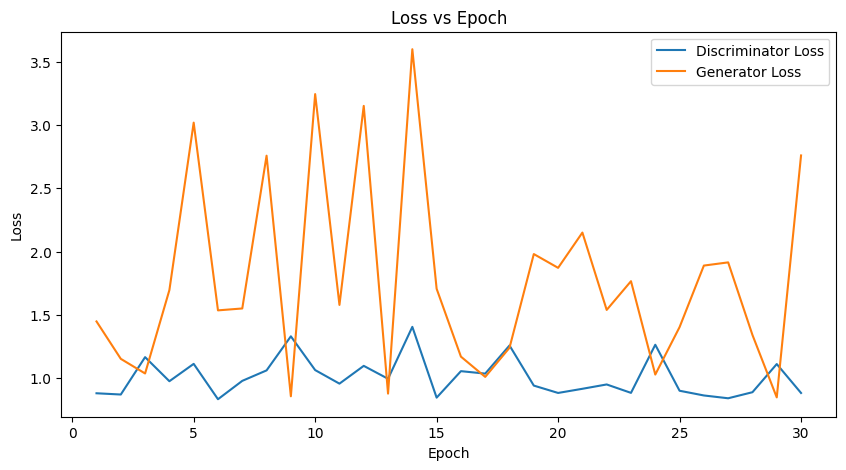

In [13]:
# Plot the Loss vs Epoch curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), d_losses, label='Discriminator Loss')
plt.plot(range(1, epochs + 1), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

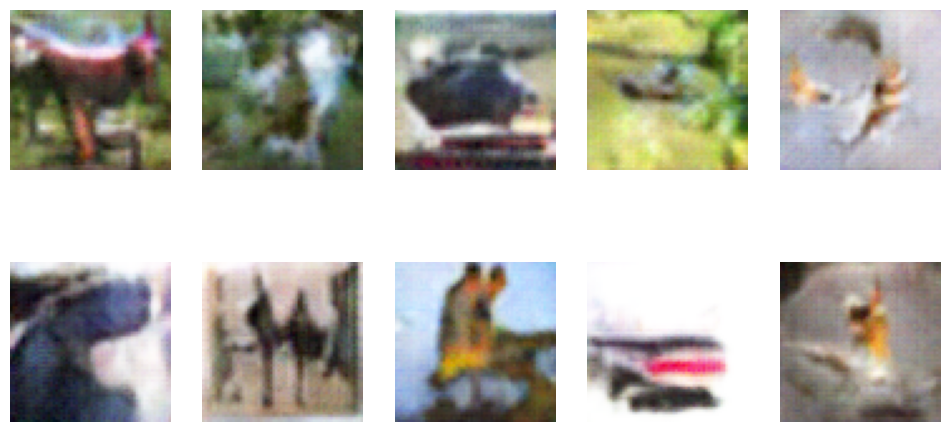

In [40]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

netG.load_state_dict(torch.load("generator.pth"))
netG.eval()
generated_images = []

# Generate and save 10 images
num_images_to_generate = 10
for i in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)
    fake_image = netG(noise).detach().cpu()
    generated_images.append(fake_image)
    vutils.save_image(fake_image, f"generated_image_{i+1}.png", normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num_images_to_generate):
    img = plt.imread(f"generated_image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

In [41]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)
    inception_model = models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


print("Calculating Inception Score...")
print(inception_score(generated_images, cuda=True, batch_size=10, resize=True, splits=1))


Calculating Inception Score...
(2.6048785078200014, 0.0)


## Generator:
### Input:  
- The Generator takes a random noise vector (nz) as input, typically sampled from a Gaussian distribution.

### Architecture:
- A series of transpose convolutional layers (ConvTranspose2d) is used for upscaling the input noise vector gradually.
- Each ConvTranspose2d layer is followed by BatchNorm2d for stabilization and ReLU activation.
- The final layer uses a ConvTranspose2d followed by Tanh activation to generate the output.
### Output: 
The output of the Generator is an image (nc) that aims to resemble samples from the true data distribution.

## Discriminator:
### Input: 
- The Discriminator takes an image (nc) as input.

### Architecture:
- A series of convolutional layers (Conv2d) are used for downscaling the input image.
- Similar to the Generator, BatchNorm2d is used after some convolutional layers to stabilize the training process.
- Leaky ReLU activation is used after each convolutional layer except for the final layer.
- The final layer consists of a Conv2d layer with a Sigmoid activation, outputting a single value representing the probability of the input being real or fake.

### Initialization:
- Weight initialization is performed using the weights_init function:
- For Conv layers, weights are initialized from a normal distribution with mean 0 and standard deviation 0.02.
- For BatchNorm layers, weights are initialized to 1 and biases to 0.